Covid 19 CT scan Image classification with VGG19 pretrained model.

Datasets: 2 public datasets stored in the folders CT_DATA (CT_COVID and CT_NonCovid) and SARS-COV-2-DATA.
https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset

https://github.com/UCSD-AI4H/COVID-CT



In [1]:
from builtins import range, input

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [2]:
#Code to run it in Google Colab

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#Path to data

cov_path = "/content/drive/MyDrive/Colab Notebooks/CTCov/CT_Data/CT_COVID/"
norm_path = "/content/drive/MyDrive/Colab Notebooks/CTCov/CT_Data/CT_NonCOVID/"

In [4]:
epochs = 300
batch_size=32
#define paths
covid_path = '/content/drive/MyDrive/Colab Notebooks/CTCov/SARS-COV-2-Data/COVID'
noncovid_path = '/content/drive/MyDrive/Colab Notebooks/CTCov/SARS-COV-2-Data/NON-COVID'

# Use glob to grab images from path
cov_files = glob(cov_path + '/*')
norm_files = glob(norm_path + '/*')

covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
# Fetch Images and Class Labels from Files
cov_labels = []
norm_labels = []

cov_images=[]
norm_images=[]

for i in range(len(cov_files)):
  image = cv2.imread(cov_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  cov_images.append(image) # append image
  cov_labels.append('CT_COVID') #append class label
  
for i in range(len(norm_files)):
  image = cv2.imread(norm_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  norm_images.append(image)
  norm_labels.append('CT_NonCOVID')

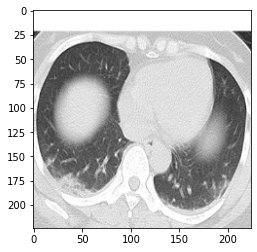

In [ ]:
#Example of our data
plt.imshow(cov_images[10])

In [ ]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') #append class label
  
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

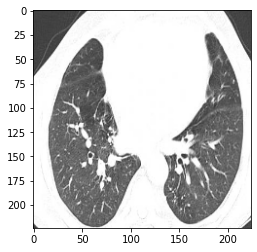

In [ ]:
#Example of data
plt.imshow(covid_images[10])

In [ ]:
#Join the 2 image datas by each category
cov_img_all = np.concatenate((covid_images, cov_images), axis=0)
norm_img_all = np.concatenate((noncovid_images, norm_images),axis=0)

In [ ]:
#Join the labels by category
covid_labels = np.concatenate((covid_labels, cov_labels), axis=0)
noncovid_labels = np.concatenate((noncovid_labels, norm_labels),axis=0)

In [ ]:
#Normalize 
covid_images = np.array(cov_img_all)/255
noncovid_images = np.array(norm_img_all)/255

In [ ]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)


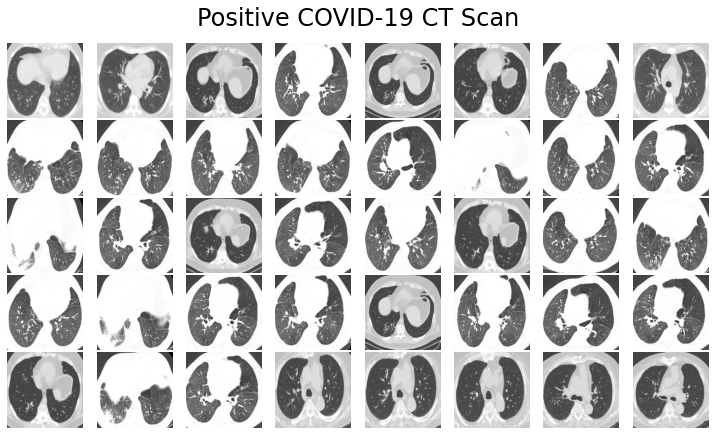

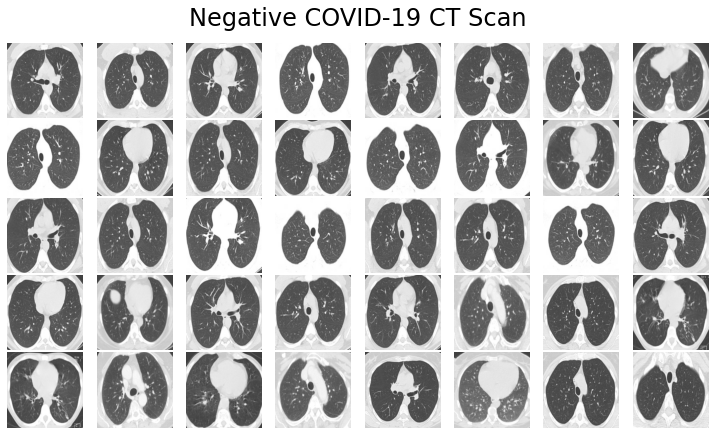

In [ ]:
# look at some images
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
    
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

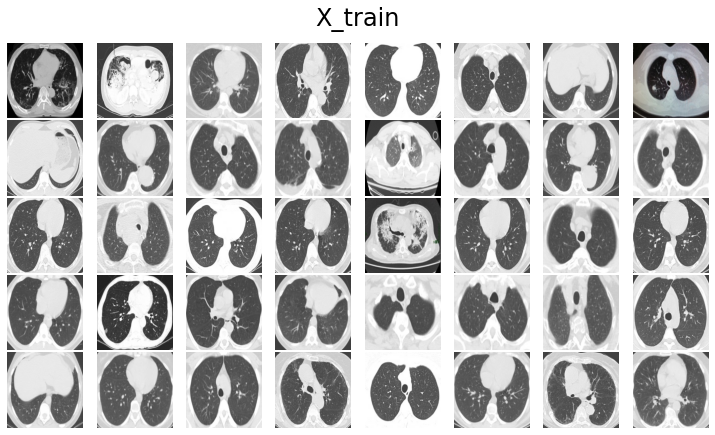

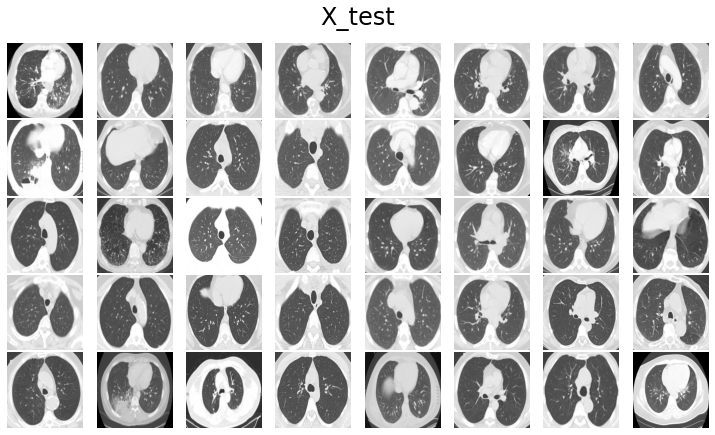

In [ ]:
#Samples of our train and test data
plot_images(X_train, 'X_train')
plot_images(X_test, 'X_test')

# VGG model

In [ ]:
from tensorflow.keras.applications import VGG19

# Building Model
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

#freeze convolutional layers
for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

#Image Data Augmentation
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/300
80/80 [==============================] - 39s 347ms/step - loss: 0.8591 - accuracy: 0.6109 - val_loss: 0.5019 - val_accuracy: 0.7740
Epoch 2/300
80/80 [==============================] - 25s 311ms/step - loss: 0.7343 - accuracy: 0.6691 - val_loss: 0.4977 - val_accuracy: 0.7678
Epoch 3/300
80/80 [==============================] - 25s 313ms/step - loss: 0.6141 - accuracy: 0.7230 - val_loss: 0.5847 - val_accuracy: 0.7198
Epoch 4/300
80/80 [==============================] - 25s 313ms/step - loss: 0.6009 - accuracy: 0.7339 - val_loss: 0.4501 - val_accuracy: 0.8158
Epoch 5/300
80/80 [==============================] - 25s 314ms/step - loss: 0.5998 - accuracy: 0.7397 - val_loss: 0.4473 - val_accuracy: 0.8127
Epoch 6/300
80/80 [==============================] - 25s 314ms/step - loss: 0.5703 - accuracy: 0.7521 - val_loss: 0.4815 - val_accuracy: 0.7663
Epoch 7/300
80/80 [==============================] - 25s 312ms/step - loss: 0.5528 - accuracy: 0.7634 - val_loss: 0.9718 - val_accuracy:

In [ ]:
# Save Model and Weights
model.save('/content/drive/MyDrive/Colab Notebooks/CTCov/Models/vgg_ct.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/CTCov/Models/vgg_weights_ct.hdf5')

In [ ]:
#Predictions
y_pred = model.predict(X_test, batch_size=batch_size)

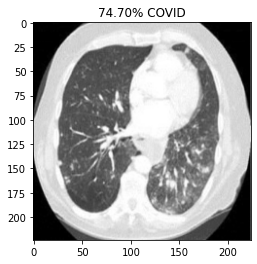

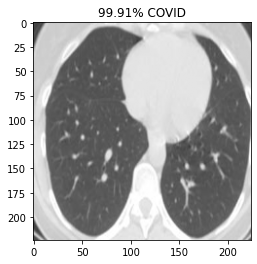

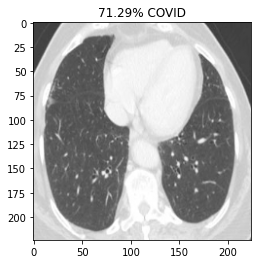

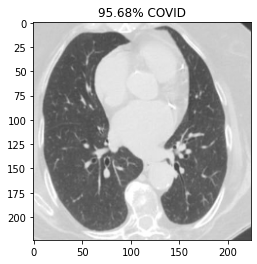

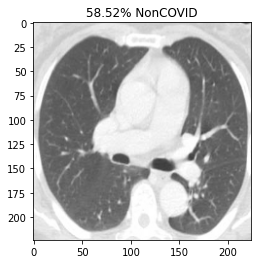

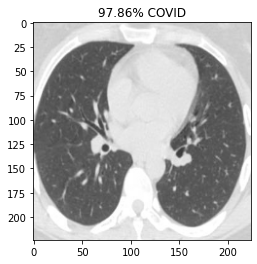

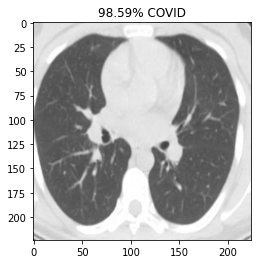

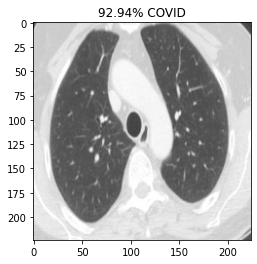

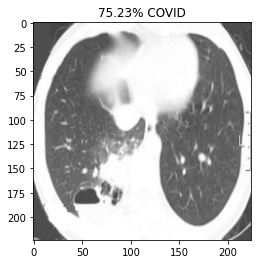

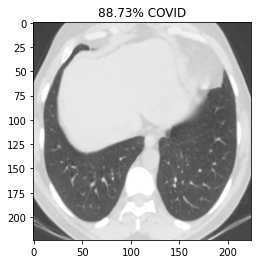

In [ ]:
#Look at some predictions
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
#Classification Report
from sklearn.metrics import classification_report
report = classification_report(y_test_bin, y_pred_bin, output_dict=True)
print(report)

{'0': {'precision': 0.8, 'recall': 0.8875, 'f1-score': 0.8414814814814814, 'support': 320}, '1': {'precision': 0.8762886597938144, 'recall': 0.7822085889570553, 'f1-score': 0.8265802269043759, 'support': 326}, 'accuracy': 0.8343653250773994, 'macro avg': {'precision': 0.8381443298969072, 'recall': 0.8348542944785275, 'f1-score': 0.8340308541929287, 'support': 646}, 'weighted avg': {'precision': 0.8384986115987361, 'recall': 0.8343653250773994, 'f1-score': 0.8339616533202796, 'support': 646}}


In [ ]:
#Show classification report as dataframe
import pandas as pd
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.800000,0.887500,0.841481,320.000000
1,0.876289,0.782209,0.826580,326.000000
accuracy,0.834365,0.834365,0.834365,0.834365
macro avg,0.838144,0.834854,0.834031,646.000000
weighted avg,0.838499,0.834365,0.833962,646.000000


In [ ]:
#save classification report to csv: 
report_csv_file = '/content/drive/MyDrive/Colab Notebooks/CTCov/VGG19_metrics/vgg_class_report.csv'
with open(report_csv_file, mode='w') as f:
    report_df.to_csv(f)

# Plots

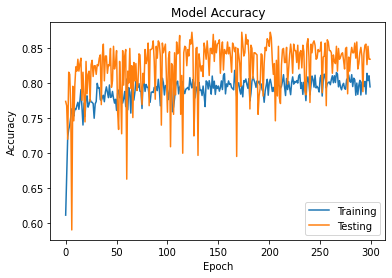

In [ ]:
plt.plot(vgg.history['accuracy'])
plt.plot(vgg.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CTCov/VGG19_metrics/vgg_ct_accuracy.png')
plt.show()

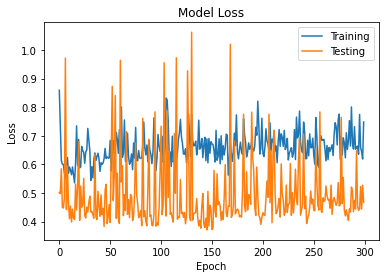

In [ ]:
plt.plot(vgg.history['loss'])
plt.plot(vgg.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CTCov/VGG19_metrics/vgg_ct_loss.png')
plt.show()

Confusion Matrix without Normalization


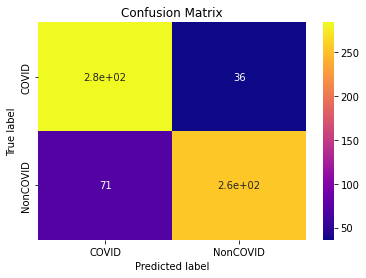

Confusion Matrix with Normalized Values


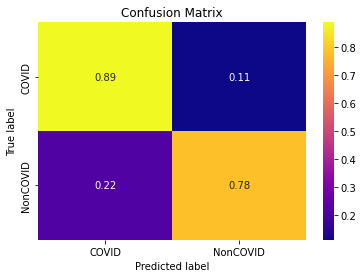

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  if normalize != 'true':
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/CTCov/VGG19_metrics/vgg_conf_matrix_not_norm.png")
  else:
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/CTCov/VGG19_metrics/vgg_conf_matrix_norm.png")
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
# convert the history to a pandas DataFrame:     
hist_df = pd.DataFrame(vgg.history) 

In [ ]:
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.859116,0.610939,0.501869,0.773994
1,0.734267,0.669123,0.497729,0.767802
2,0.614125,0.723041,0.584741,0.719814
3,0.600865,0.733902,0.450147,0.815789
4,0.599803,0.739721,0.447267,0.812693


In [ ]:
# save to json:  
hist_json_file = '/content/drive/MyDrive/Colab Notebooks/CTCov/VGG19_metrics/vgg_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/Colab Notebooks/CTCov/VGG19_metrics/vgg_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)